# Homework 2 (HW2)

By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in `sklearn`;
- Carry out simple multivariate regression analyses using `statsmodels`;
- Use propensity score matching to estimate treatment effects;

---

## Important Dates

- Homework release: Fri 15 Nov 2024
- **Homework due**: Fri 29 Nov 2024, 23:59
- Grade release: Mon 09 Dec 2024

---

##  Some rules

1. You are allowed to use any built-in Python library that is included in the `requirements.txt` for this homework. If you use any additional library, this may complicate the grading process, and we reserve the right to penalize your grade for unnecessary complexity of the solution. All the questions can be solved with the libraries in `requirements.txt`.
2. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, we will **not grade** anything.
3. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
4. In continuation to the previous point on additional library, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!

**A Note on using Language Models (LMs)**

If you try hard enough, you will likely get away with cheating. Fortunately, our job is not to police, but rather to educate! So, please consider the following:

Presumably, you are taking this course to learn something! LMs are not always right ([they often fail in silly ways](https://community.openai.com/t/why-9-11-is-larger-than-9-9-incredible/869824/4)). This course should prepare you to detect when they are wrong!
Some of the TAs on this course literally published many works on detecting machine-generated text.

Here LLM includes but not limited to chatbots like ChatGPT, coding assistants like Copilot. Do not even use them to prettify your code or correct English. If you are caught using LLMs, you will be reported to the instructor and subject to the consequences. 


---


## Grading 
- The homework has a total of 100 points, distributed as follows:
    - Part 1: Data Preprocessing ( 20 points)
    - Part 2: Linear Regression (30 points)
    - Part 3: Supervised Learning (40 points)
    - Part 4: Propensity Score Matching (10 points)

## Context

Within EPFL's master program, you are excited to start an internship as a data scientist.
After rounds of interviews, you have been selected to work with the biggest car dealership in Switzerland !

Your mentor at the company Tim, has explained to you that the company is interested in a pricing model for used cars. 

- Tim: "We have a lot of used cars in our inventory, and we need to determine the price at which we should sell these cars. We have some ideas about the factors that influence the price of a used car, but so far we have just been using our experience and intuition to determine the price of a used car. Sometimes it works, but probably we can do better and a more data-driven approach would also help our new employees in the sales team as they have less experience."

- You: "That sounds like a great project! What kind of data do we have?"

- Tim: "We sell all kinds of cars here, but maybe we can start with a specific brand and model. For example, the Toyota Corolla is the best-selling car worldwide in 2023, and we have a lot of data on it. We can start by analyzing the data on used Toyota Corolla cars. If it works well, we can extend the analysis to other brands."

The dataset contains the following columns:

- `Age`: Age of the car in months.
- `Mileage`: Number of distance the car has been driven. (km or miles)
- `FuelType`: Fuel type of the car (Petrol, Diesel, or CNG)
- `HP`: Horsepower
- `MetColor`: Is the color of the car metallic? (Yes=1, No=0)
- `Automatic`: Is the car automatic? (Yes=1, No=0)
- `CC`: Cylinder volume in cubic centimeters
- `Doors`: Number of doors
- `Weight`: Weight of the car in kilograms
- `Price`: Price of the car in euros


## Data

The data is provided in the `data` folder and it contains the following 3 csv files:
- `Task1-2.ToyotaCorolla-clean.csv` and `Task1-2.ToyotaCorolla-raw.csv` for Part 1 and Part 2
- `Task3.ToyotaCorolla_sales_3months.csv` for Part 3
- `Task4.ToyotaCorolla_discount_sales` for Part 4

You should not use any other data source for this homework.

## References:

The data is based on the ToyotaCorolla dataset from the UCI Machine Learning Repository [here](https://archive.ics.uci.edu/ml/datasets/Toyota+Corolla).
We have made some modifications to the original dataset, so please use the data provided in the `data` folder in the course repo.

## Task 1 (20 pts) - Get to know the data

In [112]:
import random
import pandas as pd
import numpy as np
import networkx as nx
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.metrics import classification_report, r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score as f1_score_sklearn

# fix random seed for reproducibility
np.random.seed(42)
random.seed(42)


**1.1 (2 pts)**: Load the data from the file `Task1-2.ToyotaCorolla-raw.csv` into a pandas DataFrame. Display the first 5 rows of the DataFrame. Hint: A naive loading of the data will raise an error. You will need to figure out how to load the data correctly. (Hint: localise which row is causing the error)

In [113]:
# The error comes from the row 33: 
# 15,646.9,22,21862.732919254657,Petrol,97,1,0,1400,3,1100,GBP
# Unlike the other rows with currency GBP, this one doesn't have quotation marks arround the price
# (which is problematic since the rows with currency GBP have a comma in the price value, 
# and read_csv function separates columns by commas)
# We fixed this by adding quotation marks arround the price value directly in the csv file

DATA_FOLDER = 'data/'
df_raw = pd.read_csv(DATA_FOLDER + 'Task1-2.ToyotaCorolla-raw.csv')
df_raw.head(5)

,Price,Age,Mileage,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,Currency
0,13500.0,23.0,46986.0,Diesel,90.0,1.0,0.0,2000.0,3.0,1165.0,EURO
1,11878.0,23.0,72937.0,Diesel,90.0,1.0,0.0,2000.0,3.0,1165.0,CHF
2,12050.0,24.0,41711.0,Diesel,90.0,1.0,0.0,2000.0,3.0,1165.0,CHF
3,12914.0,26.0,48000.0,Diesel,90.0,0.0,0.0,2000.0,3.0,1165.0,CHF
4,11878.0,30.0,38500.0,Diesel,90.0,0.0,0.0,2000.0,3.0,1170.0,CHF


**1.2 (2 pts)**: Check if there are nan values in the Dataframe. If there are, try to find out which row is problematic and fix it. If you can't fix it, drop the row.

In [114]:
number_nan = df_raw.isnull().sum().sum()
print(f"There are {number_nan} nan values if the Dataframe")

if number_nan > 0:
    # We found a row with nan values that were nan because of a wrong separator
    wrong_rows = df_raw[df_raw.isna().any(axis=1)]
    print("\nProblematic rows:\n", wrong_rows)
    # This happened because of a wrong separator (; instead of ,)

    # try to fix the rows
    for i, row in wrong_rows.iterrows():    
        try: 
            content = row.iloc[0]
            if isinstance(content, str) and ";" in content:
                content = content.replace(';', ',').split(',')

                #convert the strings to float if j contains a number
                content = [float(j) if j.replace('.', '', 1).isdigit() else j for j in content]
                
                df_raw.iloc[i] = content

        except Exception as e:
            print(f"Error: {e}")

    # Drop unresolved rows
    df_raw = df_raw.dropna()
    print(f"\nFixed the rows with nan values. Now there are {df_raw.isnull().sum().sum()} nan values in the Dataframe")

There are 10 nan values if the Dataframe

Problematic rows:
                                                 Price  Age Mileage FuelType  \
906  8423.0;68;58860.0;Petrol;110;1;0;1600;3;1055;CHF  NaN     NaN      NaN   

     HP  MetColor  Automatic  CC  Doors  Weight Currency  
906 NaN       NaN        NaN NaN    NaN     NaN      NaN  

Fixed the rows with nan values. Now there are 0 nan values in the Dataframe


**1.3 (4 pts): Compute the mean, median of the `Price` column.**

1. Compute the mean and median of the `Price` column. If you encounter error, try to understand why this error is happening and propose a solution.
2. After computing the mean and median, do you think they are reasonable? If not, what could be the reason for this? 
  
Hint: Is all values in the `Price` column numerical?


Price
<class 'str'>      1436
<class 'float'>       1
Name: count, dtype: int64
Mean Price: 9439.5
Median Price: 8595.0


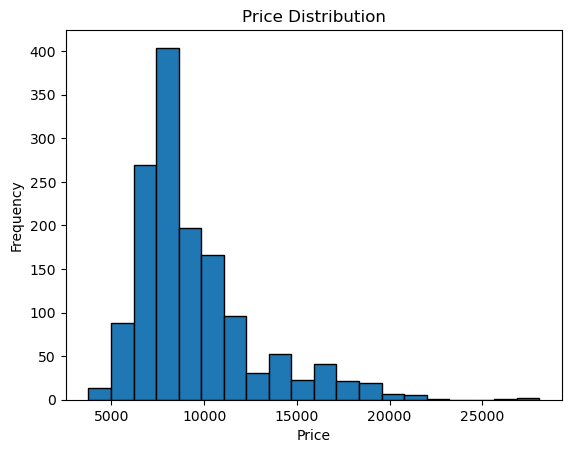

In [115]:
# 1
# Check the type of the values in the column 'Price'
types = df_raw['Price'].apply(type).value_counts()
print(types)

# The error happens due to the fact that the values in the column 'Price' are strings and not floats
# Solution to resolve the type errors is to convert the column 'Price' to float

# After examining the data, it is noticed that some values ​​cannot be converted because:
# - they contain commas like 15,646.9 (should be 15646.9)
# - they contain characters like £
# - they contain comma instead of dot for decimal values like 15,398,499999999998 (line 36 of the csv file)
# The solution is to remove these characters/replace by the correct one and then convert the column to float
def cleaning(value):
    if isinstance(value, float): 
        return value
    if isinstance(value, str) and value.count(",") > 1:
        value = '.'.join(value.rsplit(',', 1))
    if isinstance(value, str):
        value = value.replace("£", "").replace(",", "")
        return float(value)  
    
df_raw['Price'] = df_raw['Price'].apply(cleaning)

# Compute mean, median and standard deviation of 'Price'
mean = df_raw['Price'].mean()
median = df_raw['Price'].median()

print(f"Mean Price: {mean:.1f}")
print(f"Median Price: {median:.1f}")

plt.hist(df_raw['Price'], bins=20, edgecolor='k')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

After computing the mean and median, the results are as follows:
- **Mean Price**: 9,439.5
- **Median Price**: 8,595.0

The results are reasonable. The median price seems representative of the typical price of a used Toyota Corolla, as it is less affected by outliers. However, the mean price being higher than the median suggests that the distribution of prices is **right-skewed**, which is common in pricing data.

**1.4 (4 pts): Convert Units**

From now on, we will work with the cleaned data `Task1-2.ToyotaCorolla-clean.csv`. Read it into a DataFrame.

You notice that some prices are in CHF (Swiss Francs), while others are in EUR (Euros) or GBP (British Pounds). Additionally, for cars priced in GBP, the mileage is in miles rather than kilometers.

For consistency, convert all prices to CHF and all distances to kilometers.

- Exchange rates:
  - 1 CHF = 1.05 EUR
  - 1 GBP = 1.15 CHF
  - 1 mile = 1.61 km

Make the following conversions:
1. Convert prices in EUR or GBP to CHF, rounding to the nearest integer.
2. Convert distances in miles (for GBP cars) to kilometers, rounding to the nearest integer.
3. Drop the 'Currency' column.
4. Calculate the min, mean, median and max of the 'Price' and 'Distance' columns after the conversion.

In [116]:
df_clean = pd.read_csv(DATA_FOLDER + 'Task1-2.ToyotaCorolla-clean.csv')

EURO_TO_CHF_FACTOR = 1/1.05
GBP_TO_CHF_FACTOR = 1.15
MILE_TO_KM_FACTOR = 1.61

# Convert prices in EURO to CHF
df_clean.loc[df_clean['Currency'] == 'EURO', 'Price'] *= EURO_TO_CHF_FACTOR
# Convert prices in GBP to CHF
df_clean.loc[df_clean['Currency'] == 'GBP', 'Price'] *= GBP_TO_CHF_FACTOR
# Round prices to nearest integer
df_clean['Price'] = df_clean['Price'].round()

# Convert Mileage to km
df_clean.loc[df_clean['Currency'] == 'GBP', 'Mileage'] *= MILE_TO_KM_FACTOR
# Round Mileage to nearest integer
df_clean['Mileage'] = df_clean['Mileage'].round()

# Drop the 'Currency' column
df_clean = df_clean.drop(columns=['Currency'])

print("Statistics for 'Price' column after conversion:")
print(f"Min: {df_clean['Price'].min()}")
print(f"Mean: {df_clean['Price'].mean()}")
print(f"Median: {df_clean['Price'].median()}")
print(f"Max: {df_clean['Price'].max()}")

print("\nStatistics for 'Mileage' column after conversion:")
print(f"Min: {df_clean['Mileage'].min()}")
print(f"Mean: {df_clean['Mileage'].mean()}")
print(f"Median: {df_clean['Mileage'].median()}")
print(f"Max: {df_clean['Mileage'].max()}")

Statistics for 'Price' column after conversion:
Min: 3758.0
Mean: 9423.536211699164
Median: 8595.0
Max: 28074.0

Statistics for 'Mileage' column after conversion:
Min: 1.0
Mean: 68533.25974930362
Median: 63389.5
Max: 243000.0


**1.5 (2 pts): Analyze Average Price**

A.  Print the average price for each fuel type. Determine which fuel type has the highest average price.

B.  Print the average price for different numbers of doors. Determine which number of doors has the highest average price.

In [117]:
# A. Average price for each fuel type
fuel_avg_price = df_clean.groupby('FuelType')['Price'].mean()
print(fuel_avg_price)

# Fuel type with the highest average price
print(f"\nFuel type with the highest average price: {fuel_avg_price.idxmax()} ({fuel_avg_price.max():.1f} CHF)")

FuelType
CNG       8383.235294
Diesel    9878.619355
Petrol    9381.722310
Name: Price, dtype: float64

Fuel type with the highest average price: Diesel (9878.6 CHF)


In [118]:
# B. Average price for each number of doors
doors_avg_price = df_clean.groupby('Doors')['Price'].mean()
print(doors_avg_price)

# Number of doors with the highest average price
print(f"\nNumber of doors with the highest average price: {doors_avg_price.idxmax()} doors ({doors_avg_price.max():.1f} CHF)")

Doors
2     6997.500000
3     8898.673633
4     8604.384058
5    10082.823442
Name: Price, dtype: float64

Number of doors with the highest average price: 5 doors (10082.8 CHF)


**1.6 (2 pts): Relationship Between Car Age and Price**

It is intuitive that an older car tends to be cheaper, and a car with more mileage might also be less expensive. 

To explore this intuition, create two scatter plots:
1. Car Age vs Price
2. Mileage vs Price

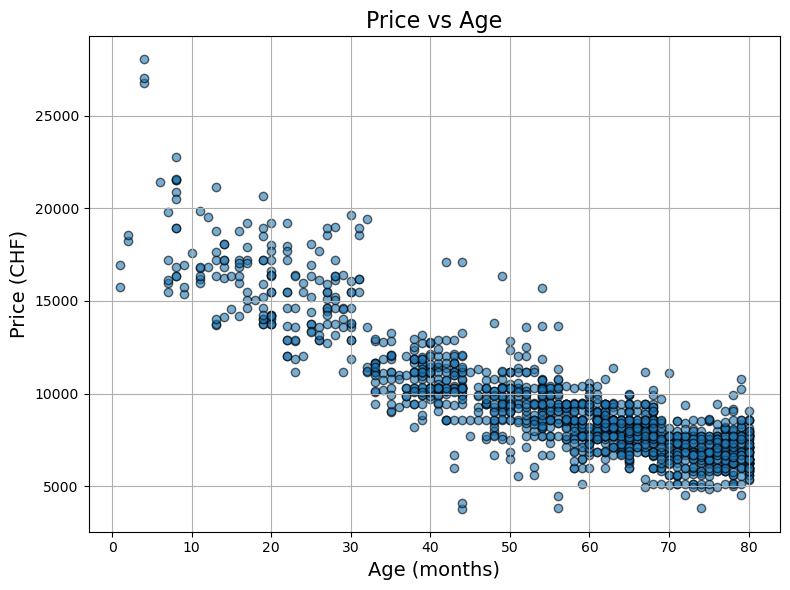

In [119]:
# 1
# Plot car age VS price in a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['Age'], df_clean['Price'], alpha=0.6, edgecolor='k')
plt.xlabel('Age (months)', fontsize=14)
plt.ylabel('Price (CHF)', fontsize=14)
plt.title('Price vs Age', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

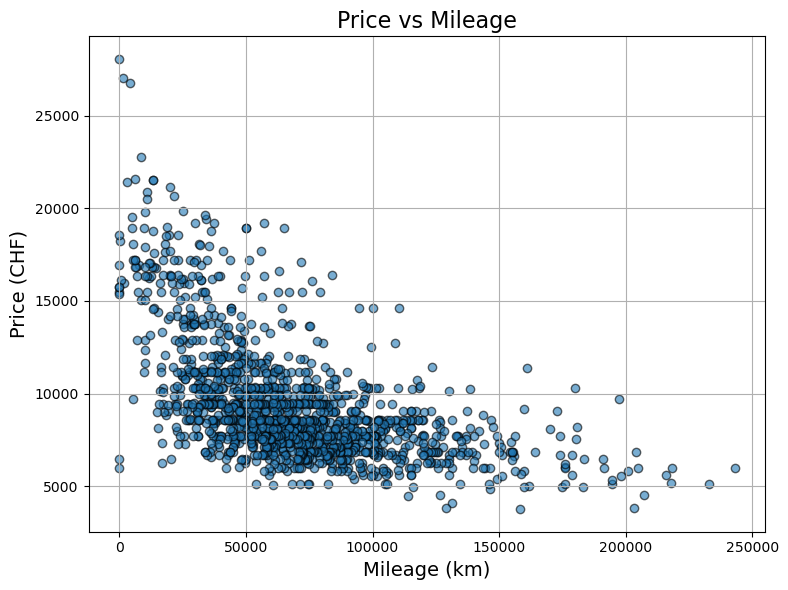

In [120]:
# 2
# Plot car mileage VS price in a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['Mileage'], df_clean['Price'], alpha=0.6, edgecolor='k')
plt.xlabel('Mileage (km)', fontsize=14)
plt.ylabel('Price (CHF)', fontsize=14)
plt.title('Price vs Mileage', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

**1.7 (4 pts): Correlation Between Price and Mileage**

The relationship between car price and mileage appears non-linear, with a steeper price drop initially followed by a flatter curve.

A.(2 pts)  Calculate both the Pearson and Spearman correlations between the price of the car and the distance driven.


In [121]:
print(stats.pearsonr(df_clean['Mileage'], df_clean['Price']))
print(stats.spearmanr(df_clean['Mileage'], df_clean['Price']))

PearsonRResult(statistic=-0.563415665460653, pvalue=4.4912025598497645e-121)
SignificanceResult(statistic=-0.6053559019304245, pvalue=2.600905720179522e-144)



B.(2 pts)  Which correlation value is higher? Does this result align with your expectations?

The **Spearman correlation** (-0.605) is higher in magnitude than the **Pearson correlation** (-0.563).


This result aligns with expectations, since we have that : 
- The Pearson correlation measures the strength of a **linear relationship** between `Mileage` and `Price`. Its value is lower because the relationship is not perfectly linear. After the first few miles of the car, the price drop because the car isn't new anymore.
- The Spearman correlation measures the strength of a **monotonic relationship**. The relationship is not linear but remains always decreasing. It fits better the data and thus result in higher coefficient.

PS: You can see a **negative correlation** since both Pearson and Spearman correlations confirm a negative relationship between mileage and price as you can see in the results and in the scatter plot. Which is intuitive: cars with higher mileage indeed have lower prices.

## Part 2 Linear Regression (30 pts)

You want to build a linear regression model to predict the price of a car based on the features you have.



**2.0 (8 pts) Helper functions**

Before building machine learning models, how to asses performance is crucial. Hence we first implement some helper functions to asses the performance of our model. We can use these later throughout the exercise.

Implement the `accuracy` , `precision`, `recall` and `f1_score` functions with the following requirements:

1. These functions should take in the true labels(`np.array`) and the predicted labels(`np.array`) and return the corresponding metric. 
2. They should follow the convention that the positive class is 1 and the negative class is 0.
3. Apply the functions to the following data:

```python
true_labels = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])
predicted_labels = np.array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])
```

Compare the results with the implementation in `sklearn` and see if they match.

In [122]:
def calculate_confusion_matrix_elements(y_true, y_pred):
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))
    return true_positive, false_positive, false_negative


def accuracy(true_labels, predicted_labels):
    return np.mean(true_labels == predicted_labels)

def precision(true_labels, predicted_labels):
    true_positive, false_positive, _ = calculate_confusion_matrix_elements(true_labels, predicted_labels)
    positive_predictions = true_positive + false_positive
    return true_positive / positive_predictions if positive_predictions != 0 else 0

def recall(true_labels, predicted_labels):
    true_positive, _, false_negative = calculate_confusion_matrix_elements(true_labels, predicted_labels)
    actual_positives = true_positive + false_negative
    return true_positive / actual_positives if actual_positives != 0 else 0

def f1_score(true_labels, predicted_labels):
    prec = precision(true_labels, predicted_labels)
    rec = recall(true_labels, predicted_labels)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

In [123]:
# Example data
true_labels = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])
predicted_labels = np.array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

# Custom implementation
custom_accuracy = accuracy(true_labels, predicted_labels)
custom_precision = precision(true_labels, predicted_labels)
custom_recall = recall(true_labels, predicted_labels)
custom_f1 = f1_score(true_labels, predicted_labels)

# sklearn implementation
sklearn_accuracy = accuracy_score(true_labels, predicted_labels)
sklearn_precision = precision_score(true_labels, predicted_labels)
sklearn_recall = recall_score(true_labels, predicted_labels)
sklearn_f1 = f1_score_sklearn(true_labels, predicted_labels)

print(f"Custom Accuracy: {custom_accuracy:.2f}, Sklearn Accuracy: {sklearn_accuracy:.2f}")
print(f"Custom Precision: {custom_precision:.2f}, Sklearn Precision: {sklearn_precision:.2f}")
print(f"Custom Recall: {custom_recall:.2f}, Sklearn Recall: {sklearn_recall:.2f}")
print(f"Custom F1 Score: {custom_f1:.2f}, Sklearn F1 Score: {sklearn_f1:.2f}")

Custom Accuracy: 0.70, Sklearn Accuracy: 0.70
Custom Precision: 0.67, Sklearn Precision: 0.67
Custom Recall: 0.80, Sklearn Recall: 0.80
Custom F1 Score: 0.73, Sklearn F1 Score: 0.73


We can notice that the our functions and the ones from sklearn library give the same outputs


**2.1 (6 pts) Preprocess the Data**

To prepare your data for building a linear regression model, complete the following steps:

A.(1 pts) Convert the categorical variables to one-hot encoding using the `pd.get_dummies()` function, how many columns do you have after the one-hot encoding? (P.S. You may want to avoid introducing multicollinearity with one-hot encoding, what should you do to avoid this?)


In [124]:
num_columns = df_clean.shape[1]
print(f"Number of columns before one-hot encoding: {num_columns}")

# One-hot encode the FuelType and Doors columns
# MeltColor and Automatic columns are already binary, so they don't need to be one-hot encoded
# Drops one category per variable (drop_first=True) to avoid multicollinearity
df_one_hot_encoded = pd.get_dummies(df_clean, columns=['FuelType', 'Doors'], drop_first=True)

num_columns = df_one_hot_encoded.shape[1]
print(f"Number of columns after one-hot encoding: {num_columns}")

Number of columns before one-hot encoding: 10
Number of columns after one-hot encoding: 13


B.(1 pts) Split the data into features (X) and target (y) variables. The target variable is the 'Price' column. Then split the data into train test sets using a 80-20 split. Use `random_state=42` for reproducibility. How many samples are in the training set and how many samples are in the test set?


In [125]:
y = df_one_hot_encoded['Price']  # Target
X = df_one_hot_encoded.drop(columns=['Price'])  # Features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"There are {X_train.shape[0]} in the training set")
print(f"There are {X_test.shape[0]} in the test set")

There are 1148 in the training set
There are 288 in the test set


C.(1 pts) Why do we split the data into only train-test sets but not train-validation-test sets? 

In this case, we use only a train-test split for its simplicity and the fact that we don't have hyper parameters to tune. Therefore, there is no need for a separate validation set to select the best parameter values, that would add unnecessary complexity without significant benefit. Since the model does not require parameter tuning and the task is relatively simple, a train-test split is sufficient for evaluating the model’s performance.

D.(1 pts) **Standardize the Features**: Use `StandardScaler` from `sklearn.preprocessing` and then add a constant column using `sm.add_constant()`. Print the average and standard deviation of the training set after standardization.

In [126]:
scaler = StandardScaler()

scaler.fit(X_train)

print("Feature-wise mean of training set before scaling:")
print(scaler.mean_)
print("\nFeature-wise standard deviation of training set before scaling:")
print(scaler.scale_)

# Transform the data
X_train_scaled = scaler.transform(X_train)
X_train_scaled = sm.add_constant(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = sm.add_constant(X_test_scaled)

print("\nFeature-wise mean of training set after scaling:")
print(X_train_scaled.mean(axis=0))

print("\nFeature-wise standard deviation of training set after scaling:")
print(X_train_scaled.std(axis=0))

Feature-wise mean of training set before scaling:
[5.58135889e+01 6.88806089e+04 1.01242160e+02 6.62891986e-01
 5.66202091e-02 1.56801394e+03 1.07292596e+03 1.13240418e-01
 8.71951220e-01 4.30313589e-01 9.58188153e-02 4.72125436e-01]

Feature-wise standard deviation of training set before scaling:
[1.87642654e+01 3.76833798e+04 1.48402844e+01 4.72722118e-01
 2.31115471e-01 1.90115318e+02 5.08719502e+01 3.16886456e-01
 3.34144116e-01 4.95119990e-01 2.94342606e-01 4.99222404e-01]

Feature-wise mean of training set after scaling:
[ 1.00000000e+00  1.48545520e-16 -1.48545520e-16  3.86837291e-17
 -7.73674582e-17  4.64204749e-18 -2.96317365e-16 -6.85475679e-16
  1.00577696e-17  2.32102374e-17 -5.57045699e-17 -1.31524679e-17
 -8.66515531e-17]

Feature-wise standard deviation of training set after scaling:
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


E.(2 pts) Should we first standardize the data and then split it into train and test sets or vice versa?   why?

We should first split the data into train and test sets and then standardize the data because we want the test data to be fresh and unseen by the model. If we take it into account for standardization, model will have a taste of the test data before it has/should seen it. By calculating the mean and standard deviation of the training set only, we ensure that the test set remains completely independent, unbiased and realistic.

**2.2 (10 pts) Train and Evaluate the Linear Regression Model**

To train and evaluate a linear regression model using the `statsmodels` library, complete the following steps:

1. (2 pts) Train a linear regression model on the training dataset using `sm.OLS` from `statsmodels`, print the summary of the model using `model.summary()`.


In [127]:
linear_regression_model = sm.OLS(y_train, X_train_scaled).fit()
print(linear_regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     536.0
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:57:58   Log-Likelihood:                -9803.5
No. Observations:                1148   AIC:                         1.963e+04
Df Residuals:                    1135   BIC:                         1.970e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9441.4983     36.725    257.086      0.0

2. (2 pts) Evaluate the model on the test dataset using the square root of the mean squared error (RMSE) metric. 
   1. Report the RMSE value.
   2. Your boss wants to know how far off the model's predictions are from the actual price of the car. What would you tell him? Given a number and explain how you got it.


In [128]:
y_pred = linear_regression_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse} CHF")


Root Mean Squared Error (RMSE): 1434.3390492274818 CHF


The Root Mean Squared Error (RMSE) is **1434 CHF**, which means that, on average, the model's predictions deviate by approximately 1434 CHF from the true car prices.

This value was calculated as the square root of the mean squared error, which is the average of the squared differences between the predicted and actual values. The RMSE provides an estimate of the error magnitude in the model's predictions.

We can say that the model captures general trends even if for some cases, it might be to far from the good price.

3. (2 pts) Report the R² score on the test dataset and interpret it.


In [129]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score on Test Dataset: {r2}")

R² Score on Test Dataset: 0.8122727616953432


The R² score provides a measure of how well the model explains the variability of the variable (`Price`) based on the input features. 

In this case, **R² = 0.81**, meaning the model explains **81% of the variability** in car prices.

4.  (2 pts) Which features are statistically significant at a 5% significance level? 

In [130]:
significance_level = 0.05

# Get feature names
feature_names = X.columns.tolist()

# Identify statistically significant features at 5% significance level
print("Statistically significant features at 5% significance level:")
for i, pv in enumerate(linear_regression_model.pvalues[1:]): # Skip the constant term
    if pv < significance_level:
        print(f"Feature {feature_names[i]}")

Statistically significant features at 5% significance level:
Feature Age
Feature Mileage
Feature HP
Feature CC
Feature Weight
Feature FuelType_Diesel
Feature FuelType_Petrol


5.  (2 pts) Determine which two feature have the highest coefficient? What does it imply?

In [131]:
df_coefficients = pd.DataFrame({
    'Feature': X.columns.tolist(),  # Feature names
    'Coefficient': linear_regression_model.params.values[1:] # Coefficients
})
df_coefficients = df_coefficients.sort_values(by='Coefficient', key=abs, ascending=False)
top_2_features = df_coefficients.head(2)
print("Top 2 Features with the Highest Coefficients:")
print(top_2_features)

Top 2 Features with the Highest Coefficients:
  Feature  Coefficient
0     Age -1971.973191
6  Weight  1152.956431


The two features with the highest coefficients are:

- Age: Coefficient = -1971.97
This implies that for every additional month in the age of a car, its price decreases by approximately **1972 CHF**, assuming all other factors remain constant.

- Weight: Coefficient = 1152.96
This implies that for every additional kilogram in the weight of a car, its price increases by approximately **1153 CHF**, assuming all other factors remain constant.

**2.3 (2 pts): Improvement Discussion**

- Suggest a few additional features that could potentially explain this remaining variance in the data ( at least 2 features).

There are several other features that can directly influence the price of the car, including:

1. Car Type: Different car types (such as sedan, hatchback, SUV) have different price ranges. For example, SUVs are generally more expensive than sedans due to their larger size. Including a categorical variable for car type could help capture this variation in prices.

2. Car Condition: A car in better condition would likely have a higher price. It would be possible to assess the condition of the car, taking into account a series of criteria (such as the presence of dents or scratches, car painting, the condition of the upholstery, etc.), and thus assigning a grade (grade A, B, C ...).

3. Seats Number: Although it also has a certain relationship with the number of doors, the relationship is not completely direct. For example, cars with 3 doors can have from 2 to 5 seats. The number of seats ends up being more decisive when making a purchase decision, and therefore, it is also reflected in the price of the car.

4. Accident History: Cars that have been involved in accidents tend to have a lower price. It would be possible to include a variable that indicates whether the car has been involved in an accident and, if so, the severity of the accident.

5. Average Fuel Consumption: Cars with lower fuel consumption are more attractive to buyers, as they are more economical in the long run. This feature could also help explain the remaining variance in the data.

**2.4 (2 pts): Identifying Confounding Variables**

The feature "Weight" shows a very low p-value and a high coefficient, but it doesn't seem to be a major factor for customers buying a second-hand car. You go to your mentor Tim to discuss this issue. Indeed, Tim suggests that never in his career has he seen a customer who asked for the weight of a car before buying it.
You suspect that there might be a confounding variable that is correlated with the car's weight and significantly influences its price.

- Suggest a possible confounding variable that may be correlated with the car's weight and significantly influence its price (it doesn't need to be a variable in the dataset). Explain why this variable could be a confounding variable.

The weight of the car is a variable that ends up being directly influenced by the car type. A family car, for example, is usually heavier, and since it is a car that has more features and is more sought after, it is also more expensive. The type of car acts as a confounding variable because it is correlated with both the weight of the car and its price. While weight seems to have a significant connection to price, this relationship is probably influenced by the type of car, which more directly reflects the car's value.

**2.5 (2 pts): Adding an Inverse Mileage Term**

From the previous scatter plot, the relationship between car price and mileage appears non-linear, with a steep price drop initially and then a flattening. A suitable approach to model this behavior is by incorporating an inverse term of mileage.

- Add the inverse mileage term to the model and retrain it using the code provided. Print the model summary and interpret the effect of the inverse mileage term.
  

In [132]:
# Add inverse mileage term
df_one_hot_encoded['Inverse_Mileage'] = 1 / df_one_hot_encoded['Mileage']

# Target and features
y = df_one_hot_encoded['Price']
X = df_one_hot_encoded.drop(columns=['Price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = sm.add_constant(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = sm.add_constant(X_test_scaled)

# Train the model with the added inverse mileage term
linear_regression_model = sm.OLS(y_train, X_train_scaled).fit()
print(linear_regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     496.1
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:58:00   Log-Likelihood:                -9801.7
No. Observations:                1148   AIC:                         1.963e+04
Df Residuals:                    1134   BIC:                         1.970e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9441.4983     36.685    257.367      0.0

As we can see by the model summary, adding the inverse mileage term had very little impact, albeit positive. For example the log-likelihood went from -9803.5 to -9801.7, which is better, but very slightly so. The same can be said about the adjusted R-squared. It can also be observed that the AIC and BIC stayed the same.

## Part 3 Supervised Learning (40 pts)


After completing your analysis, you're satisfied with the results. You handed the Jupyter notebook over to your mentor.

(Fun fact: The name "Jupyter" is derived from Julia, Python, and R—three programming languages that the platform was originally designed for.)

Your mentor Tim is very impressed with your work and asks you the following question:

“
This looks great! It will be very useful for our sales team. While looking at the results, I realized that there might be one thing that we can improve. 
For companies like us, it is important to sell the cars quickly. If we are patient, we might be able to sell the car for a higher price, but that’s not always the best strategy. We need to consider the maintenance costs for the car, the cash flow and the fact that the price of the car decreases over time."

He then continues:
"Three months is a sweet spot for us. If we can sell the car within the first three months, it is great. If not, it is worth considering lowering the price to sell it faster and increase our cash flow. I can ask Ivan from Sales to collect data in the last few months on whether the car was sold within the first three months or not. This would be great if you could have a model that tells us if the car will be sold in the first three months or not. "

This sparks your interest, and soon Ivan has provided you with the new data containing an additional column `sold_within_3_months` which is a binary variable indicating whether the car was sold within the first three months or not.

Note: The data for this part is in the file `Task3.ToyotaCorolla_sales_3months.csv` and it has already unified the currency and distance units.

In [133]:
data_df = pd.read_csv('data/Task3.ToyotaCorolla_sales_3months.csv', index_col=0)
data_df.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,sold_within_3_months
0,13500,23,46986,Diesel,90,1,0,2000,3,1165,0
1,13750,23,72937,Diesel,90,1,0,2000,3,1165,0
2,13950,24,41711,Diesel,90,1,0,2000,3,1165,0
3,14950,26,48000,Diesel,90,0,0,2000,3,1165,0
4,13750,30,38500,Diesel,90,0,0,2000,3,1170,0



**3.1 (2 pts): Preprocess the Data**
1. （1 pts）How many cars in the dataset were sold in the first three months, and how many were not? 

In [134]:
counts = data_df['sold_within_3_months'].value_counts()

print(f"Number of cars not sold within 3 months: {counts[0]}")
print(f"Number of cars sold within 3 months: {counts[1]}")

Number of cars not sold within 3 months: 556
Number of cars sold within 3 months: 880


2. (1 pts) Preprocess the categorical variables to one-hot encoding using the `pd.get_dummies()` function.

In [135]:
# number of columns before one-hot encoding
print(f"Number of columns before one-hot encoding: {data_df.shape[1]}")

# categorical columns to encode
categorical_columns = ['FuelType', 'Doors']  # only features

# Perform one-hot encoding on specified categorical features
data_df_one_hot_encoded = pd.get_dummies(data_df, columns=categorical_columns, drop_first=True)

# Display the number of columns after one-hot encoding
print(f"Number of columns after one-hot encoding: {data_df_one_hot_encoded.shape[1]}")

# new column names
print("\nColumn names after one-hot encoding:")
print(data_df_one_hot_encoded.columns.tolist())

Number of columns before one-hot encoding: 11
Number of columns after one-hot encoding: 14

Column names after one-hot encoding:
['Price', 'Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Weight', 'sold_within_3_months', 'FuelType_Diesel', 'FuelType_Petrol', 'Doors_3', 'Doors_4', 'Doors_5']


**3.2 (20 pts): Logistic Regression Model**

1. (2 pts) Split the data into features (X) and target (y) variables. The target variable is the 'sold_within_3_months' column. The `Price` column should be included as a feature.

In [136]:
# Define the target variable (y) and feature matrix (X)
y = data_df_one_hot_encoded['sold_within_3_months']
X = data_df_one_hot_encoded.drop(columns=['sold_within_3_months'])

2. (2 pts) Then split the data into train test sets using a 80-20 split. Use `random_state=42` for reproducibility. 

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3. (2 pts) Standardize the features using `StandardScaler` from `sklearn.preprocessing` and then add a constant column using `sm.add_constant()`.

In [138]:
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a constant column to the scaled datasets
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

4. (2 pts) Fit a logistic regression model on the training dataset.

In [139]:
logistic_model = sm.Logit(y_train, X_train_scaled).fit(maxiter=100)

         Current function value: 0.165914
         Iterations: 100


/opt/anaconda3/envs/ada/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5. (2 pts) Evaluate the model on the test dataset using the accuracy score metric. Report the accuracy score.

In [140]:
# Predict probabilities on the test set
y_pred_probs = logistic_model.predict(X_test_scaled)

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

Accuracy Score: 0.9306


6. (2 pts) Calculate the precision, recall, and F1-score.

In [141]:
# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# Calculate F1-score
f1 = f1_score_sklearn(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")


Precision: 0.9375
Recall: 0.9483
F1-Score: 0.9429



7. (2 pts) Suppose that your company is running short on cash flow and needs to sell the cars quickly. How should you adjust the threshold for the logistic regression model to ensure that the company can sell the cars as quickly as possible?
    - A. Increase the threshold
    - B. Decrease the threshold

In a more general sense, how does the choice of threshold affect the precision and recall of the model?

In [142]:
threshold = 0.4
y_pred = (y_pred_probs > threshold).astype(int)

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

threshold = 0.6
y_pred = (y_pred_probs > threshold).astype(int)

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")


Precision: 0.9171
Recall: 0.9540
Precision: 0.9425
Recall: 0.9425


Increasing treshold implies less positive predictions (TP and FP) and better precision, but worse recall.
On the other hand, decreasing treshold implies more positive predictions (TP and FP) and better recall, but worse precision.

In a situation where the company needs to sell the cars quickly, you should decrease the threshold, making the model identify more cars that would likely not be sold within three months. Doing so will allow the company to deal with them accordingly, resulting in higher cash flow.

8. (6 pts) Use binary search to find the optimal threshold that maximizes the F1-score. Implement a binary search algorithm to find the threshold that maximizes the f1-score of the logistic regression model on the training set. The search interval should be between 0 and 1, and the stopping criterion is 10 iterations.  What is the optimal threshold and what difference does the optimal threshold make in the F1-score?

In [143]:
# Define a binary search function
def find_optimal_threshold(model, X, y, max_iters=10):
    low, high = 0.0, 1.0  # Search interval
    best_threshold = 0.5  # Default threshold
    best_f1 = 0.0         # Track the best F1-score

    for _ in range(max_iters):
        mid = (low + high) / 2

        # Predict probabilities and convert to binary predictions
        y_pred_probs = model.predict(X)
        y_pred = (y_pred_probs >= mid).astype(int)

        # Calculate the F1-score
        current_f1 = f1_score_sklearn(y, y_pred)

        # Update the best threshold and F1-score if better
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = mid

        # Adjust the interval for binary search
        # Check if moving the threshold up or down improves F1
        y_pred_lower = (y_pred_probs >= (mid - 0.01)).astype(int)
        y_pred_higher = (y_pred_probs >= (mid + 0.01)).astype(int)
        f1_lower = f1_score_sklearn(y, y_pred_lower)
        f1_higher = f1_score_sklearn(y, y_pred_higher)

        if f1_higher > f1_lower:
            low = mid  # Shift interval up
        else:
            high = mid  # Shift interval down

    return best_threshold, best_f1

# Run the binary search on the training set
optimal_threshold, optimal_f1 = find_optimal_threshold(logistic_model, X_train_scaled, y_train, max_iters=10)
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Optimal F1-Score: {optimal_f1}")
print(f"Difference of the F1-Score with the default threshold: {optimal_f1 - f1}")

Optimal Threshold: 0.4765625
Optimal F1-Score: 0.9459649122807018
Difference of the F1-Score with the default threshold: 0.003107769423558948


The optimal threshold is 0.4765625. The difference between the F1-score at the optimal threshold and at the default threshold (0.5) is 0.003. The difference is very small, but can be significant when dealing with imbalanced datasets or when the cost of false predictions is high.

**3.3(18 pts) Decision Tree Model**

Use a Decision Tree model from `sklearn` to predict whether a car will be sold within the first three months.

Follow these steps to complete the task:

1. (2 pts) Train a Decision Tree Classifier to predict the target variable (`sold_within_3_months`).You can reuse the train and test sets from the previous section. Set `random_state=42` for reproducibility in `DecisionTreeClassifier`.

In [144]:
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

2. (2 pts) Evaluate the model on the test set and report the depth of the tree.

In [145]:
# Predict on the test set
y_pred = decision_tree.predict(X_test)

# classification report
report = classification_report(y_test, y_pred, target_names=["Not Sold Within 3 Months", "Sold Within 3 Months"])
print("Classification Report:")
print(report)

# depth of the decision tree
tree_depth = decision_tree.get_depth()
print(f"Depth of the Decision Tree: {tree_depth}")

Classification Report:
                          precision    recall  f1-score   support

Not Sold Within 3 Months       0.91      0.87      0.89       114
    Sold Within 3 Months       0.92      0.94      0.93       174

                accuracy                           0.91       288
               macro avg       0.91      0.91      0.91       288
            weighted avg       0.91      0.91      0.91       288

Depth of the Decision Tree: 16


3. (2 pts) Visualize the Decision Tree

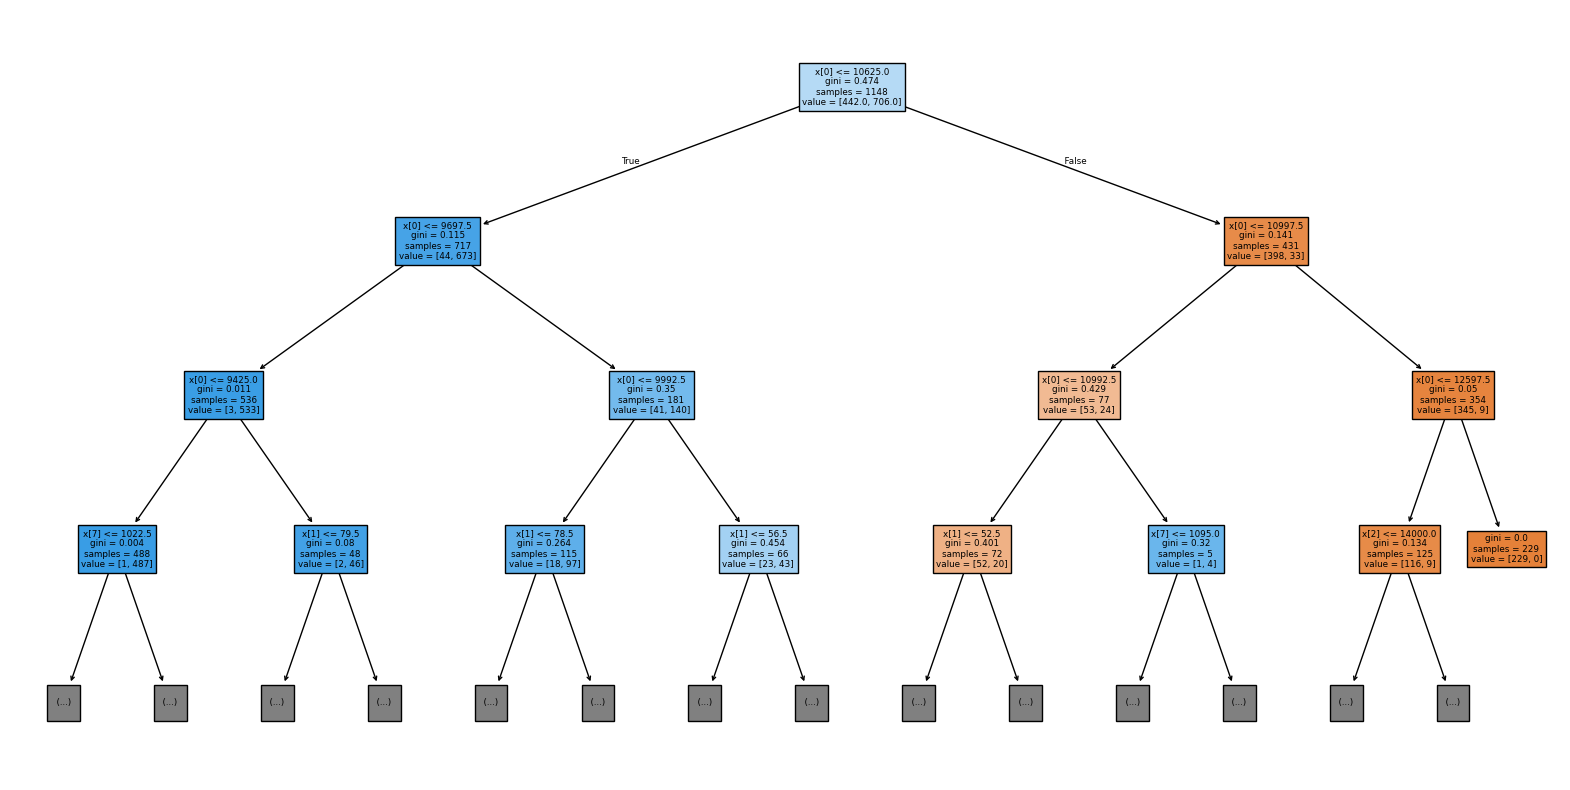

In [146]:
fig = plt.figure(figsize=(20,10))
_ = plot_tree(decision_tree, filled=True, max_depth=3) # max_depth=3 to make the tree more readable

# save to file
#fig.savefig("decistion_tree.png")

4. (2 pts) Retrain the Decision Tree Classifier with a maximum depth of 8 and evaluate it on the test set. Compare and explain the results.

In [147]:
# Decision Tree Classifier with max_depth=8
decision_tree_small = DecisionTreeClassifier(max_depth=8, random_state=42)
decision_tree_small.fit(X_train, y_train)

# Predict on the test set
y_pred_small = decision_tree_small.predict(X_test)

# classification report of the previous tree
print("Classification Report (DEPTH 16):")
print(report)
print("------------------------------------------------------------------")

# classification report
report = classification_report(y_test, y_pred_small, target_names=["Not Sold Within 3 Months", "Sold Within 3 Months"])
print("Classification Report (MAX DEPTH 8):")
print(report)

Classification Report (DEPTH 16):
                          precision    recall  f1-score   support

Not Sold Within 3 Months       0.91      0.87      0.89       114
    Sold Within 3 Months       0.92      0.94      0.93       174

                accuracy                           0.91       288
               macro avg       0.91      0.91      0.91       288
            weighted avg       0.91      0.91      0.91       288

------------------------------------------------------------------
Classification Report (MAX DEPTH 8):
                          precision    recall  f1-score   support

Not Sold Within 3 Months       0.92      0.86      0.89       114
    Sold Within 3 Months       0.91      0.95      0.93       174

                accuracy                           0.92       288
               macro avg       0.92      0.91      0.91       288
            weighted avg       0.92      0.92      0.92       288



#### Compare and explain

The results of the two trees show very similar values. However, the tree with max_depth=8 is able to obtain higher values ​​more often than the other (although the difference between the values is really small). 
We can then conclude that many leaves of the tree with greater depth do not seem to influence the final decision.
Besides that, it is important to remember that choosing a tree with less depth can reduce the likelihood of overfitting and, therefore, may sometimes be preferable. 


5. (6 pts) Train a Decision Tree Classifier for each depth from 1 to D where D is the maximum depth of the Decision Tree Classifier seen in the previous step. Evaluate each model on the test set and plot the accuracy of the models as a function of the depth and find the optimal depth.


In [148]:
max_depth = 16

# lists for depths and accuracies
depths = list(range(1, max_depth + 1))
accuracies = []

# Train and evaluate a Decision Tree for each depth
for depth in depths:
    # Train the Decision Tree with the current depth
    decision_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    decision_tree.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = decision_tree.predict(X_test)
    
    # Calculate accuracy on the test set
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

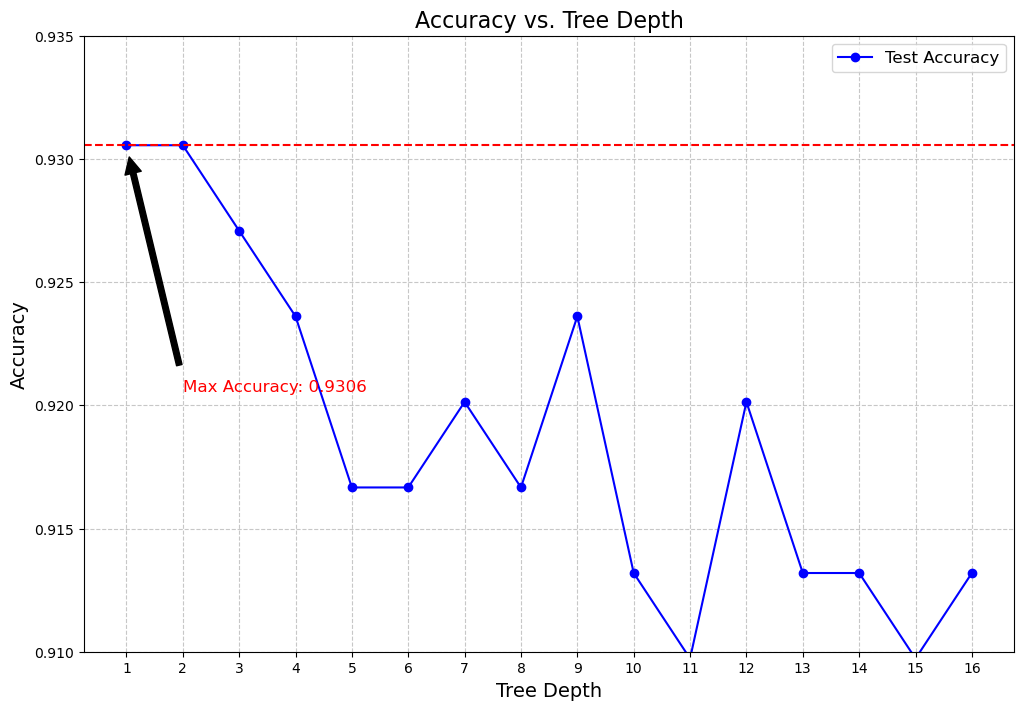

In [149]:
# Let's adjust the y-axis limits
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies, marker='o', linestyle='-', color='b', label='Test Accuracy')
plt.xlabel('Tree Depth', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs. Tree Depth', fontsize=16)
plt.xticks(depths)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=12)
plt.ylim(.91, .935)  # y-axis limits
plt.axhline(y=max(accuracies), color='r', linestyle='--', label=f'Max Accuracy: {max(accuracies):.4f}')
plt.annotate(f'Max Accuracy: {max(accuracies):.4f}', xy=(depths[accuracies.index(max(accuracies))], max(accuracies)), 
             xytext=(depths[accuracies.index(max(accuracies))] + 1, max(accuracies) - 0.01),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='r')
plt.show()

In [150]:
# Find the depth with the highest accuracy
optimal_depth = depths[accuracies.index(max(accuracies))]
optimal_accuracy = max(accuracies)

print(f"Optimal Depth: {optimal_depth}")
print(f"Accuracy at Optimal Depth: {optimal_accuracy}")

Optimal Depth: 1
Accuracy at Optimal Depth: 0.9305555555555556


6. (4 pts) Train a decision tree of depth = 1 , visualize the tree and explain what is the decision rule at the root node.

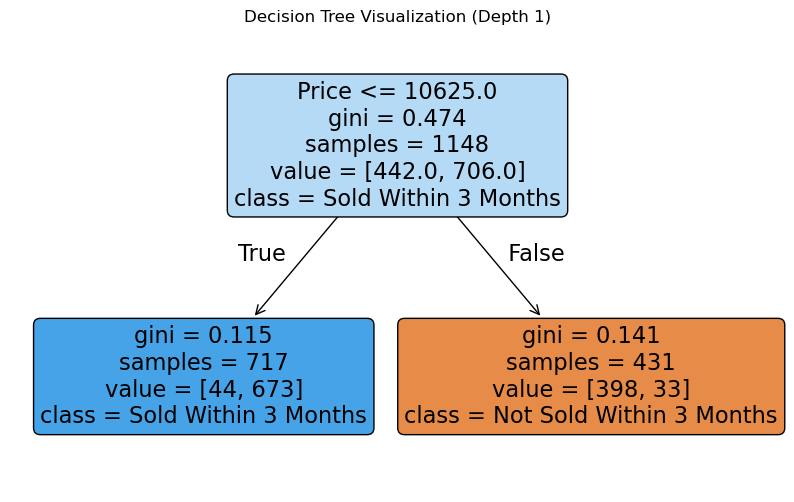

In [151]:
# Train the Decision Tree of depth 1
decision_tree_depth_1 = DecisionTreeClassifier(max_depth=1, random_state=42)
decision_tree_depth_1.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(10, 6))
plot_tree(
    decision_tree_depth_1,
    feature_names=X.columns,
    class_names=["Not Sold Within 3 Months", "Sold Within 3 Months"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualization (Depth 1)")
plt.show()

In [152]:
root_feature_name = X.columns[decision_tree_depth_1.tree_.feature[0]] # Feature name
root_threshold = decision_tree_depth_1.tree_.threshold[0]  # Feature Threshold value

print(f"Decision Rule at Root Node:")
print(f"If {root_feature_name} <= {root_threshold}, then classify as 'Sold'.")
print(f"Otherwise, classify as 'Not Sold'.")

Decision Rule at Root Node:
If Price <= 10625.0, then classify as 'Sold'.
Otherwise, classify as 'Not Sold'.


The tree has identified the `Price` feature as the most important factor in determining whether a car is sold within 3 months. Cars priced lower than or equal to 10625 are more likely to sell in 3 months, while cars priced higher tend to remain unsold.

## Part 4 Propensity Score Matching (10 pts)

Your mentor is thrilled with the progress, and he has asked Ivan to put the model into production. Based on the model's prediction, the sales manager Ivan will decide whether to lower the car's price by 5%.

A new quarter has passed, and Ivan has collected updated sales data, which includes the following columns:

- `Price`: The initial price of the car.
- `Pred_Prob`: The predicted probability of the car being sold within the first three months.
- `Applied_Discount`: Whether the discount was applied (Yes=1, No=0).
- `Discounted_Price`: The car's final price, calculated as `Price * 95%` if the discount was applied; otherwise, it's equal to `Price`.
- `Sold_within_3_months`: Whether the car was sold within the first three months (Yes=1, No=0).

Your task is to estimate the causal effect of the discount on sales within the first three months using propensity score matching.

In [153]:
data_df = pd.read_csv('data/Task4.ToyotaCorolla_discount_sales.csv', index_col=0)
print(data_df.head())

   Price  Pred_Prob  Applied_Discount  Discounted_Price  Sold_within_3_months
0  12750       0.01                 1           11475.0                     1
1  21950       0.00                 1           19755.0                     1
2   9950       0.79                 0            9950.0                     1
3   9930       0.91                 1            8937.0                     0
4   9450       0.97                 0            9450.0                     0


**4.1 (1 pts): How many samples are in the treated group, and how many are in the control group?**

In [154]:
# Count the number of samples in each group
group_counts = data_df['Applied_Discount'].value_counts()

print(f"Treated Group (Applied_Discount = 1): {group_counts.get(1, 0)} samples")
print(f"Control Group (Applied_Discount = 0): {group_counts.get(0, 0)} samples")

Treated Group (Applied_Discount = 1): 82 samples
Control Group (Applied_Discount = 0): 118 samples



**4.2 (5 pts): Propensity Score Matching**
- The propensity score is the predicted probability of the car being sold within the first three months from the logistic regression model, i.e. `Pred_Prob` column in the `Task4.ToyotaCorolla_discount_sales.csv` file. Create pairs of matched samples as follows:
  - For each treated sample (discount applied), find a control sample (discount not applied) with a difference in propensity score of less than 0.05.
  - If there is more than one control sample for a treated sample, choose the control sample with the smallest difference in propensity score.
  - If there is no control sample satisfying the condition, discard the treated sample.
  - How many successful matches did you get?

Notice that your output should be 1-to-1 matching, meaning that each treated sample should be matched with at most one control sample.
So each sample can only appear once in the pairs.

In [155]:
threshold = 0.05
treated_samples = data_df[data_df['Applied_Discount'] == 1]
control_samples = data_df[data_df['Applied_Discount'] == 0]

# Create a graph
G = nx.Graph()

# Create nodes for treated and control samples
treated_nodes = [f"treated_{i}" for i in treated_samples.index]
control_nodes = [f"control_{i}" for i in control_samples.index]

# Add nodes to the graph, with a bipartite attribute
G.add_nodes_from(treated_nodes, bipartite=0)
G.add_nodes_from(control_nodes, bipartite=1)

# Add edges based on propensity score difference condition
for treated_idx, treated_row in treated_samples.iterrows():
    for control_idx, control_row in control_samples.iterrows():
        # Calculate the absolute difference in propensity scores
        propensity_diff = abs(treated_row['Pred_Prob'] - control_row['Pred_Prob'])
        
        # If the difference is less than 0.05, we add an edge
        if propensity_diff < 0.05:
            G.add_edge(f"treated_{treated_idx}", f"control_{control_idx}", weight=1/propensity_diff if propensity_diff != 0 else 1)

# Find the maximum matching in the graph
matching = nx.max_weight_matching(G)

matches = []
for node1, node2 in matching:
    treated_idx = node1 if node1.startswith('treated') else node2
    control_idx = node2 if node2.startswith('control') else node1
    treated_idx = int(treated_idx.split('_')[1])
    control_idx = int(control_idx.split('_')[1])
    matches.append((treated_idx, control_idx))
    
matches_df = pd.DataFrame(matches, columns=["Treated_Index", "Control_Index"]).sort_values(by="Treated_Index")
num_matches = len(matching)

print(f"Number of successful matches with difference in propensity score of less than {threshold}: {num_matches}")
print(matches_df)

Number of successful matches with difference in propensity score of less than 0.05: 49
    Treated_Index  Control_Index
36              0             32
28              1             35
44              3            173
38              5            142
18              6             75
20              7            198
27             11            168
34             13            191
12             14             87
3              21            190
11             25            179
35             26             52
15             36            187
45             39            186
39             40            167
48             44            165
14             46            174
6              47            166
22             59             85
2              67            158
23             77            127
41             81            156
0              83            101
37             84            154
13             96            148
21             99            177
31            103     

**4.3 (4 pts): Average Treatment Effect (ATE)**

Now let's estimate the effect of the discount on sales. 

For each matched pair, there is one treated sample and one control sample. They may have different outcomes and we can calculate the average treatment effect (ATE) as 

$$ ATE = \frac{1}{N} \sum_i^N  y_{treat}^{(i)} - y_{\\control}^{(i)} $$ 

where $y_{treat}^{(i)}$ and $y_{\\control}^{(i)}$ are the outcomes for the treated and control samples, respectively.

Notice that here the outcome is a simple binary variable, which is whether the car was sold within the first three months or not.

1. (3 pts) Calculate the ATE based on the matched pairs and report the result



In [156]:
# Calculate the ATE
if num_matches > 0:
    matched_data = matches_df.merge(data_df, left_on="Treated_Index", right_index=True, suffixes=("_Treated", ""))
    matched_data = matched_data.merge(data_df, left_on="Control_Index", right_index=True, suffixes=("", "_Control"))
    matched_data['Outcome_Diff'] = matched_data['Sold_within_3_months'] - matched_data['Sold_within_3_months_Control']
    att = matched_data['Outcome_Diff'].mean()
    print(f"Average Treatment Effect (ATT): {att}")
else:
    print("No matches found, so we cannot calculate the ATT")

Average Treatment Effect (ATT): 0.46938775510204084


2. (1 pts) What is your conclusion about the effect of the discount on sales within the first three months?

We can observe that applying a discount of 5% increases the likelihood of a car being sold within the first three months by approximately 46.94% compared to cars that did not receive the discount. 
This result shows that the discount strategy is pretty effective in encouraging customers to make quicker purchasing decisions.